In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# node에서 받지 않은것들: retriever, rag_chain, llm(general_answer_node)

from retrievers import create_qdrant_retriever, create_compression_retriever
from rag import create_rag_chain
from state import GraphState
from nodes import *

retriever = create_qdrant_retriever()
rag_chain = create_rag_chain()

In [3]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

# 그래프 상태 초기화
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("query_expand", QueryRewriteNode())  # 질문 재작성
workflow.add_node("query_rewrite", QueryRewriteNode())  # 질문 재작성
workflow.add_node("web_search", WebSearchNode())  # 웹 검색
workflow.add_node("retrieve", RetrieveNode(retriever))  # 문서 검색
workflow.add_node("grade_documents", FilteringDocumentsNode())  # 문서 평가
workflow.add_node(
    "general_answer", GeneralAnswerNode(ChatOpenAI(model="gpt-4o", temperature=0))
)  # 일반 답변 생성
workflow.add_node("rag_answer", RagAnswerNode(rag_chain))  # RAG 답변 생성

# 엣지 추가
workflow.add_conditional_edges(
    START,
    RouteQuestionNode(),
    {
        "query_expansion": "query_expand",  # 웹 검색으로 라우팅
        "general_answer": "general_answer",  # 벡터스토어로 라우팅
    },
)

workflow.add_edge("query_expand", "retrieve")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_web_search_node,
    {
        "web_search": "web_search",  # 웹 검색 필요
        "rag_answer": "rag_answer",  # RAG 답변 생성 가능
    },
)

workflow.add_edge("query_rewrite", "rag_answer")

workflow.add_conditional_edges(
    "rag_answer",
    AnswerGroundednessCheckNode(),
    {
        "relevant": END,
        "not relevant": "web_search",
        "not grounded": "query_rewrite",
    },
)

workflow.add_edge("web_search", "rag_answer")


# 그래프 컴파일
app = workflow.compile(checkpointer=MemorySaver())

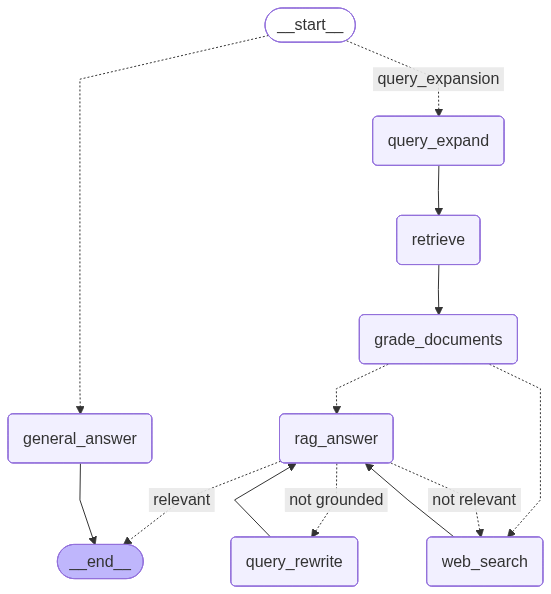

In [4]:
app

In [5]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid


def ask(question):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=20, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "question": question,
    }

    # 스트리밍 형식으로 그래프 실행
    stream_graph(
        app,
        inputs,
        config,
    )

In [6]:
ask("대한민국의 수도는?")


🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: general_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
대한민국의 수도는 서울입니다.

In [7]:
ask("Self-RAG 에서 사용되는 관련성 평가 노드 예제를 찾아줘")


🔄 Node: __start__ 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: query_expand 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Can you provide an example of a relevance evaluation node used in Self-RAG within the langgraph repository?
🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2

🔄 Node: rag_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Self-RAG에서 langgraph 저장소 내에서 사용되는 relevance evaluation 노드 예시는 다음과 같이 구현할 수 있습니다. Self-RAG는 LLM이 스스로 출력의 질과 관련성을 평가하고, 필요 시 재검색(retrieval)이나 재생성(generation)을 수행하는 구조입니다. 이 과정에서 relevance evaluation 노드는 사용자 질문과 생성된 답변, 그리고 검색된 문서들의 관련성을 평가하는 역할을 합니다.

아래는 Self-RAG에서 자주 사용되는 relevance evaluation 노드의 예시 코드입니다. 이 코드는 질문(question), 생성된 답변(generation), 그리고 검색된 문서들(documents)을 받아서 관련성을 평가하는 구조입니다.

```python
def relevance_evaluation_node(state: dict) -> str:
    """
    Self-RAG에서 relevance evaluation을 수행하는 노드 예시

    Args:
        state (dict): 현재 그래프 상태로, 'question', 'generation', 'documents'

In [8]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid


def invoke_ask(question):
    # config 설정(재귀 최대 횟수, thread_id)
    config = RunnableConfig(
        recursion_limit=20, configurable={"thread_id": random_uuid()}
    )

    # 질문 입력
    inputs = {
        "question": question,
    }

    # 스트리밍 형식으로 그래프 실행
    invoke_graph(
        app,
        inputs,
        config,
    )

In [9]:
invoke_ask("Self-RAG 에서 사용되는 관련성 평가 노드 예제를 찾아줘")


🔄 Node: query_expand 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
Can you provide an example of a relevance evaluation node used in Self-RAG within the langgraph repository?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
page_content='# How to Set Up a LangGraph Application with requirements.txt

A LangGraph application must be configured with a [LangGraph configuration file](../reference/cli.md#configuration-file) in order to be deployed to LangGraph Platform (or to be self-hosted). This how-to guide discusses the basic steps to setup a LangGraph application for deployment using `requirements.txt` to specify project dependencies.

This walkthrough is based on [this repository](https://github.com/langchain-ai/langgraph-example), which you can play around with to learn more about how to setup your LangGraph application for deployment.

!!! tip "Setup with pyproject.toml"
    If you prefer using poetry for dependency management, check out [this 